In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
# Load example data
data_df = mavenn.load_example_dataset('sortseq_full-wt')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head()

test N: 10,269
training + validation N: 40,249


,set,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,x
0,validation,2,0,0,0,0,0,0,0,0,0,AATTGATGTCCGGTAGCTCACTCATTAGGCAGCCAAGGTTTTAGAC...
1,training,0,0,0,1,0,0,0,0,0,0,AATTCATGTGAGTTATGTCTCTCATTAGGCACCCCAGGCTTGAGAT...
2,training,1,0,0,0,0,0,0,0,0,0,AATTAATGTGAGTTAGCTCACTCATTGGACACCCCAGGCTTTACAC...
3,training,0,1,0,0,0,0,0,0,0,0,ACTTAATAAAAGTCAGCTCACTCATTAATCACCCCACGCTCTACAT...
4,training,0,0,0,0,0,3,0,0,0,0,AATTAATGTGAGTTATCTAACTCATTAGGCACCCCAGGCTTTACAC...


In [3]:
# Comptue sequence length and number of bins
L = len(data_df['x'][0])
y_cols = data_df.columns[1:-1]
Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=75, Y=10


In [4]:
from mavenn.src.layers.gpmap import CustomGPMapLayer


# Tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Layer, Dense

class ThermodynamicLayer(CustomGPMapLayer):
    """Represents an thermodynamic model of transcription
       regulation in E. Coli at the lac promoter, which 
       contains binding sites for RNAP and CRP.
    """

    def __init__(self, 
                 TF_start,
                 TF_end,
                 RNAP_start,
                 RNAP_end,
                 C,
                 regularizer, 
                 *args, **kwargs):
        """Construct layer instance."""
        
        # set attributes
        self.TF_start = TF_start
        self.TF_end = TF_end        
        self.RNAP_start = RNAP_start
        self.RNAP_end = RNAP_end        
        self.C=C
        self.regularizer = tf.keras.regularizers.L2(regularizer)
        
        # form helpful variables
        self.L_TF = TF_end-TF_start
        self.L_RNAP = RNAP_end - RNAP_start
        
        super().__init__(*args, **kwargs)

    def build(self, input_shape):
        """Build layer."""
        
        # define bias/chemical potential weight for crp
        self.mu_TF = self.add_weight(name='mu_TF',
                                       shape=(1,),
                                       initializer=Constant(1.),
                                       trainable=True,
                                       regularizer=self.regularizer)

        # define bias/chemical potential weight for rnap
        self.mu_RNAP = self.add_weight(name='mu_RNAP',
                                       shape=(1,),
                                       initializer=Constant(1.),
                                       trainable=True,
                                       regularizer=self.regularizer)


        # Define theta_TF_lc parameters
        theta_TF_lc_shape = (1, self.L_TF, self.C)

        theta_TF_lc_init = np.random.randn(*theta_TF_lc_shape)/np.sqrt(self.L_TF)
        self.theta_TF_lc = self.add_weight(name='theta_TF_lc',
                                        shape=theta_TF_lc_shape,
                                        initializer=Constant(theta_TF_lc_init),
                                        trainable=True,
                                        regularizer=self.regularizer)
        
        # Define theta_rnap_lc parameters
        theta_RNAP_lc_shape = (1, self.L_RNAP, self.C)

        theta_RNAP_lc_init = np.random.randn(*theta_RNAP_lc_shape)/np.sqrt(self.L_RNAP)
        self.theta_RNAP_lc = self.add_weight(name='theta_RNAP_lc',
                                        shape=theta_RNAP_lc_shape,
                                        initializer=Constant(theta_RNAP_lc_init),
                                        trainable=True,
                                        regularizer=self.regularizer)
        
        # define interaction term. Not sure if this needs regularization
        self.interaction = self.add_weight(name='interaction',
                               shape=(1,),
                               initializer=Constant(0),
                               trainable=True,
                               regularizer=tf.keras.regularizers.L2(0))
        
        # define tsat term. Not sure if this needs regularization
        self.tsat = self.add_weight(name='tsat',
                               shape=(1,),
                               initializer=Constant(1.),
                               trainable=True,
                               regularizer=tf.keras.regularizers.L2(0))        
        
        # Call superclass build
        super().build(input_shape)

    def call(self, x_lc):
        """Process layer input and return output.
        
        x_lc: (tensor)
            Input tensor that represents one-hot encoded 
            sequence values. 
        """
        
        # extract locations of binding sites from entire lac-promoter sequence.
        x_TF_lc = x_lc[:,self.C * self.TF_start:self.C * self.TF_end]
        x_RNAP_lc = x_lc[:,self.C * self.RNAP_start: self.C * self.RNAP_end]
        
        # reshape according to crp and rnap lengths. 
        x_TF_lc = tf.reshape(x_TF_lc, [-1, self.L_TF, self.C])
        x_RNAP_lc = tf.reshape(x_RNAP_lc, [-1, self.L_RNAP, self.C])
                
        # compute delta G for crp    
        phi_TF = self.mu_TF + \
              tf.reshape(K.sum(self.theta_TF_lc * x_TF_lc, axis=[1, 2]),
                         shape=[-1, 1])
            
        # compute delta G for rnap
        phi_RNAP = self.mu_RNAP + \
              tf.reshape(K.sum(self.theta_RNAP_lc * x_RNAP_lc, axis=[1, 2]),
                         shape=[-1, 1])            
        
        # compute rate of transcription
        t = (self.tsat)*(K.exp(-phi_RNAP)+K.exp(-phi_TF-phi_RNAP-self.interaction))/(1+K.exp(-phi_TF)+K.exp(-phi_RNAP)+K.exp(-phi_TF-phi_RNAP-self.interaction))
        
        # return rate of transcription
        return t


In [5]:
# define custom gp_map parameters dictionary
gpmap_kwargs = {'TF_start':1,
                'TF_end':27,
                'RNAP_start':34,
                'RNAP_end':75,
                'C':4,
                'regularizer':0.1}

# Create model
model = mavenn.Model(L=L, 
                     Y=Y,
                     alphabet='dna', 
                     regression_type='MPA', 
                     gpmap_type='custom',
                     gpmap_kwargs=gpmap_kwargs,
                     custom_gpmap=ThermodynamicLayer)

In [6]:
# Set training data
model.set_data(x=data_df['x'],
               y=data_df[y_cols],
               validation_flags=(data_df['set']=='validation'),
               shuffle=True)

# Fit model to data
model.fit(learning_rate=.00025,
          epochs=1000,
          batch_size=100,
          early_stopping=True,
          early_stopping_patience=25,
          linear_initialization=True)


N = 40,249 observations set as training data.
Using 24.7% for validation.
Data shuffled.
Time to set data: 0.655 sec.
Epoch 1/1000
304/304 [==============================] - 3s 5ms/step - loss: 358.0087 - I_var: -0.0012 - val_loss: 355.2596 - val_I_var: 8.2507e-05
Epoch 2/1000
304/304 [==============================] - 1s 3ms/step - loss: 351.6463 - I_var: 4.3861e-04 - val_loss: 348.5757 - val_I_var: 0.0017
Epoch 3/1000
304/304 [==============================] - 1s 2ms/step - loss: 343.6341 - I_var: 0.0027 - val_loss: 342.4485 - val_I_var: 0.0061
Epoch 4/1000
304/304 [==============================] - 1s 3ms/step - loss: 339.4214 - I_var: 0.0101 - val_loss: 336.4597 - val_I_var: 0.0173
Epoch 5/1000
304/304 [==============================] - 1s 2ms/step - loss: 330.8385 - I_var: 0.0269 - val_loss: 330.0957 - val_I_var: 0.0406
Epoch 6/1000
304/304 [==============================] - 1s 2ms/step - loss: 325.8087 - I_var: 0.0600 - val_loss: 322.9446 - val_I_var: 0.0810
Epoch 7/1000
304/304 

Epoch 57/1000
304/304 [==============================] - 1s 4ms/step - loss: 272.9859 - I_var: 0.5261 - val_loss: 274.4297 - val_I_var: 0.5264
Epoch 58/1000
304/304 [==============================] - 1s 3ms/step - loss: 272.0809 - I_var: 0.5296 - val_loss: 274.6686 - val_I_var: 0.5235
Epoch 59/1000
304/304 [==============================] - 1s 2ms/step - loss: 270.2853 - I_var: 0.5294 - val_loss: 274.3384 - val_I_var: 0.5270
Epoch 60/1000
304/304 [==============================] - 1s 3ms/step - loss: 270.5852 - I_var: 0.5312 - val_loss: 274.2273 - val_I_var: 0.5281
Epoch 61/1000
304/304 [==============================] - 1s 2ms/step - loss: 272.8193 - I_var: 0.5311 - val_loss: 274.0086 - val_I_var: 0.5303
Epoch 62/1000
304/304 [==============================] - 1s 2ms/step - loss: 272.1179 - I_var: 0.5288 - val_loss: 274.2034 - val_I_var: 0.5280
Epoch 63/1000
304/304 [==============================] - 1s 2ms/step - loss: 272.1253 - I_var: 0.5323 - val_loss: 273.9650 - val_I_var: 0.5305

Epoch 171/1000
304/304 [==============================] - 1s 3ms/step - loss: 268.7904 - I_var: 0.5560 - val_loss: 270.2736 - val_I_var: 0.5554
Epoch 172/1000
304/304 [==============================] - 1s 2ms/step - loss: 267.8522 - I_var: 0.5570 - val_loss: 270.3466 - val_I_var: 0.5546
Epoch 173/1000
304/304 [==============================] - 1s 2ms/step - loss: 267.8076 - I_var: 0.5543 - val_loss: 270.3378 - val_I_var: 0.5547
Epoch 174/1000
304/304 [==============================] - 1s 2ms/step - loss: 268.1367 - I_var: 0.5549 - val_loss: 270.2581 - val_I_var: 0.5553
Epoch 175/1000
304/304 [==============================] - 1s 2ms/step - loss: 267.1827 - I_var: 0.5561 - val_loss: 270.2735 - val_I_var: 0.5550
Epoch 176/1000
304/304 [==============================] - 1s 2ms/step - loss: 267.3206 - I_var: 0.5576 - val_loss: 270.2351 - val_I_var: 0.5555
Epoch 177/1000
304/304 [==============================] - 1s 2ms/step - loss: 267.3299 - I_var: 0.5554 - val_loss: 270.2595 - val_I_var:

Epoch 228/1000
304/304 [==============================] - 1s 3ms/step - loss: 269.0966 - I_var: 0.5661 - val_loss: 269.4680 - val_I_var: 0.5619
Epoch 229/1000
304/304 [==============================] - 1s 3ms/step - loss: 267.0287 - I_var: 0.5627 - val_loss: 269.3618 - val_I_var: 0.5633
Epoch 230/1000
304/304 [==============================] - 1s 3ms/step - loss: 266.1638 - I_var: 0.5631 - val_loss: 269.3183 - val_I_var: 0.5637
Epoch 231/1000
304/304 [==============================] - 1s 3ms/step - loss: 267.9790 - I_var: 0.5646 - val_loss: 269.3447 - val_I_var: 0.5633
Epoch 232/1000
304/304 [==============================] - 1s 3ms/step - loss: 267.2704 - I_var: 0.5650 - val_loss: 269.3055 - val_I_var: 0.5637
Epoch 233/1000
304/304 [==============================] - 1s 3ms/step - loss: 265.8110 - I_var: 0.5594 - val_loss: 269.2619 - val_I_var: 0.5642
Epoch 234/1000
304/304 [==============================] - 1s 3ms/step - loss: 266.5692 - I_var: 0.5649 - val_loss: 269.2217 - val_I_var:

Epoch 285/1000
304/304 [==============================] - 1s 2ms/step - loss: 265.5174 - I_var: 0.5797 - val_loss: 268.3512 - val_I_var: 0.5760
Epoch 286/1000
304/304 [==============================] - 1s 3ms/step - loss: 266.1360 - I_var: 0.5795 - val_loss: 268.2219 - val_I_var: 0.5774
Epoch 287/1000
304/304 [==============================] - 1s 2ms/step - loss: 266.0151 - I_var: 0.5738 - val_loss: 268.1992 - val_I_var: 0.5776
Epoch 288/1000
304/304 [==============================] - 1s 2ms/step - loss: 266.3720 - I_var: 0.5781 - val_loss: 268.1761 - val_I_var: 0.5779
Epoch 289/1000
304/304 [==============================] - 1s 3ms/step - loss: 266.0455 - I_var: 0.5789 - val_loss: 268.1699 - val_I_var: 0.5781
Epoch 290/1000
304/304 [==============================] - 1s 2ms/step - loss: 266.1102 - I_var: 0.5785 - val_loss: 268.1860 - val_I_var: 0.5779
Epoch 291/1000
304/304 [==============================] - 1s 3ms/step - loss: 265.4106 - I_var: 0.5796 - val_loss: 268.1318 - val_I_var:

Epoch 342/1000
304/304 [==============================] - 1s 2ms/step - loss: 264.4167 - I_var: 0.5871 - val_loss: 267.5311 - val_I_var: 0.5853
Epoch 343/1000
304/304 [==============================] - 1s 2ms/step - loss: 265.3259 - I_var: 0.5869 - val_loss: 267.4685 - val_I_var: 0.5857
Epoch 344/1000
304/304 [==============================] - 1s 2ms/step - loss: 264.4552 - I_var: 0.5868 - val_loss: 267.4173 - val_I_var: 0.5864
Epoch 345/1000
304/304 [==============================] - 1s 2ms/step - loss: 267.1113 - I_var: 0.5874 - val_loss: 267.5116 - val_I_var: 0.5853
Epoch 346/1000
304/304 [==============================] - 1s 2ms/step - loss: 263.4238 - I_var: 0.5895 - val_loss: 267.4095 - val_I_var: 0.5862
Epoch 347/1000
304/304 [==============================] - 1s 2ms/step - loss: 264.2596 - I_var: 0.5880 - val_loss: 267.4298 - val_I_var: 0.5863
Epoch 348/1000
304/304 [==============================] - 1s 3ms/step - loss: 264.5261 - I_var: 0.5857 - val_loss: 267.3586 - val_I_var:

Epoch 399/1000
304/304 [==============================] - 1s 4ms/step - loss: 264.1824 - I_var: 0.5950 - val_loss: 266.8294 - val_I_var: 0.5918
Epoch 400/1000
304/304 [==============================] - 1s 3ms/step - loss: 262.5078 - I_var: 0.5927 - val_loss: 266.8662 - val_I_var: 0.5914
Epoch 401/1000
304/304 [==============================] - 1s 2ms/step - loss: 265.2228 - I_var: 0.5929 - val_loss: 266.8973 - val_I_var: 0.5910
Epoch 402/1000
304/304 [==============================] - 1s 3ms/step - loss: 264.5343 - I_var: 0.5941 - val_loss: 266.8363 - val_I_var: 0.5917
Epoch 403/1000
304/304 [==============================] - 1s 2ms/step - loss: 265.9866 - I_var: 0.5936 - val_loss: 266.9395 - val_I_var: 0.5906
Epoch 404/1000
304/304 [==============================] - 1s 2ms/step - loss: 264.5983 - I_var: 0.5934 - val_loss: 266.8186 - val_I_var: 0.5919
Epoch 405/1000
304/304 [==============================] - 1s 2ms/step - loss: 266.1800 - I_var: 0.5916 - val_loss: 266.8154 - val_I_var:

Epoch 456/1000
304/304 [==============================] - 1s 2ms/step - loss: 262.5212 - I_var: 0.6033 - val_loss: 266.1044 - val_I_var: 0.6003
Epoch 457/1000
304/304 [==============================] - 1s 2ms/step - loss: 263.9626 - I_var: 0.6030 - val_loss: 266.1927 - val_I_var: 0.5991
Epoch 458/1000
304/304 [==============================] - 1s 2ms/step - loss: 263.1931 - I_var: 0.6032 - val_loss: 266.0757 - val_I_var: 0.6005
Epoch 459/1000
304/304 [==============================] - 1s 2ms/step - loss: 264.0098 - I_var: 0.6034 - val_loss: 266.3229 - val_I_var: 0.5979
Epoch 460/1000
304/304 [==============================] - 1s 2ms/step - loss: 262.6255 - I_var: 0.6029 - val_loss: 265.9684 - val_I_var: 0.6017
Epoch 461/1000
304/304 [==============================] - 1s 2ms/step - loss: 263.6920 - I_var: 0.6054 - val_loss: 265.9925 - val_I_var: 0.6016
Epoch 462/1000
304/304 [==============================] - 1s 2ms/step - loss: 263.3126 - I_var: 0.6038 - val_loss: 266.1314 - val_I_var:

Epoch 513/1000
304/304 [==============================] - 1s 2ms/step - loss: 260.9842 - I_var: 0.6152 - val_loss: 265.1233 - val_I_var: 0.6139
Epoch 514/1000
304/304 [==============================] - 1s 2ms/step - loss: 263.9803 - I_var: 0.6168 - val_loss: 265.1677 - val_I_var: 0.6135
Epoch 515/1000
304/304 [==============================] - 1s 2ms/step - loss: 262.5401 - I_var: 0.6170 - val_loss: 265.3553 - val_I_var: 0.6114
Epoch 516/1000
304/304 [==============================] - 1s 2ms/step - loss: 263.2511 - I_var: 0.6164 - val_loss: 265.1156 - val_I_var: 0.6142
Epoch 517/1000
304/304 [==============================] - 1s 2ms/step - loss: 263.1050 - I_var: 0.6150 - val_loss: 265.0925 - val_I_var: 0.6146
Epoch 518/1000
304/304 [==============================] - 1s 2ms/step - loss: 262.5649 - I_var: 0.6158 - val_loss: 265.4640 - val_I_var: 0.6105
Epoch 519/1000
304/304 [==============================] - 1s 2ms/step - loss: 262.9524 - I_var: 0.6182 - val_loss: 265.0686 - val_I_var:

Epoch 570/1000
304/304 [==============================] - 1s 2ms/step - loss: 263.4826 - I_var: 0.6309 - val_loss: 264.2596 - val_I_var: 0.6277
Epoch 571/1000
304/304 [==============================] - 1s 3ms/step - loss: 261.4581 - I_var: 0.6317 - val_loss: 264.1828 - val_I_var: 0.6285
Epoch 572/1000
304/304 [==============================] - 1s 2ms/step - loss: 261.7154 - I_var: 0.6308 - val_loss: 264.2910 - val_I_var: 0.6275
Epoch 573/1000
304/304 [==============================] - 1s 2ms/step - loss: 261.6891 - I_var: 0.6332 - val_loss: 264.2219 - val_I_var: 0.6283
Epoch 574/1000
304/304 [==============================] - 1s 2ms/step - loss: 260.3194 - I_var: 0.6296 - val_loss: 264.1959 - val_I_var: 0.6285
Epoch 575/1000
304/304 [==============================] - 1s 2ms/step - loss: 261.3418 - I_var: 0.6314 - val_loss: 264.2465 - val_I_var: 0.6281
Epoch 576/1000
304/304 [==============================] - 1s 3ms/step - loss: 260.3009 - I_var: 0.6301 - val_loss: 264.1967 - val_I_var:

Epoch 627/1000
304/304 [==============================] - 1s 2ms/step - loss: 260.8539 - I_var: 0.6399 - val_loss: 263.4853 - val_I_var: 0.6387
Epoch 628/1000
304/304 [==============================] - 1s 3ms/step - loss: 259.0793 - I_var: 0.6401 - val_loss: 263.4966 - val_I_var: 0.6387
Epoch 629/1000
304/304 [==============================] - 1s 3ms/step - loss: 259.5580 - I_var: 0.6417 - val_loss: 263.5699 - val_I_var: 0.6379
Epoch 630/1000
304/304 [==============================] - 1s 2ms/step - loss: 261.1626 - I_var: 0.6399 - val_loss: 263.4924 - val_I_var: 0.6387
Epoch 631/1000
304/304 [==============================] - 1s 2ms/step - loss: 260.0325 - I_var: 0.6408 - val_loss: 263.6243 - val_I_var: 0.6372
Epoch 632/1000
304/304 [==============================] - 1s 2ms/step - loss: 261.0410 - I_var: 0.6388 - val_loss: 263.4924 - val_I_var: 0.6387
Epoch 633/1000
304/304 [==============================] - 1s 3ms/step - loss: 261.9293 - I_var: 0.6436 - val_loss: 263.4857 - val_I_var:

Epoch 740/1000
304/304 [==============================] - 1s 4ms/step - loss: 260.0757 - I_var: 0.6520 - val_loss: 262.6731 - val_I_var: 0.6484
Epoch 741/1000
304/304 [==============================] - 1s 4ms/step - loss: 259.3702 - I_var: 0.6501 - val_loss: 262.6882 - val_I_var: 0.6482
Epoch 742/1000
304/304 [==============================] - 1s 3ms/step - loss: 259.0921 - I_var: 0.6499 - val_loss: 262.6634 - val_I_var: 0.6484
Epoch 743/1000
304/304 [==============================] - 1s 3ms/step - loss: 259.3729 - I_var: 0.6514 - val_loss: 262.8199 - val_I_var: 0.6468
Epoch 744/1000
304/304 [==============================] - 1s 2ms/step - loss: 259.7176 - I_var: 0.6512 - val_loss: 262.7326 - val_I_var: 0.6476
Epoch 745/1000
304/304 [==============================] - 1s 2ms/step - loss: 260.5387 - I_var: 0.6510 - val_loss: 262.7237 - val_I_var: 0.6479
Epoch 746/1000
304/304 [==============================] - 1s 2ms/step - loss: 260.9116 - I_var: 0.6489 - val_loss: 262.6220 - val_I_var:

Epoch 797/1000
304/304 [==============================] - 1s 2ms/step - loss: 258.7719 - I_var: 0.6503 - val_loss: 262.4343 - val_I_var: 0.6508
Epoch 798/1000
304/304 [==============================] - 1s 2ms/step - loss: 260.9135 - I_var: 0.6528 - val_loss: 262.6321 - val_I_var: 0.6488
Epoch 799/1000
304/304 [==============================] - 1s 2ms/step - loss: 261.2109 - I_var: 0.6545 - val_loss: 262.4171 - val_I_var: 0.6512
Epoch 800/1000
304/304 [==============================] - 1s 2ms/step - loss: 258.9347 - I_var: 0.6536 - val_loss: 262.4244 - val_I_var: 0.6510
Epoch 801/1000
304/304 [==============================] - 1s 2ms/step - loss: 260.3122 - I_var: 0.6548 - val_loss: 262.4882 - val_I_var: 0.6503
Epoch 802/1000
304/304 [==============================] - 1s 3ms/step - loss: 259.4060 - I_var: 0.6539 - val_loss: 262.4572 - val_I_var: 0.6508
Epoch 803/1000
304/304 [==============================] - 1s 3ms/step - loss: 260.6345 - I_var: 0.6540 - val_loss: 262.4073 - val_I_var:

Epoch 854/1000
304/304 [==============================] - 1s 2ms/step - loss: 258.4529 - I_var: 0.6567 - val_loss: 262.2102 - val_I_var: 0.6533
Epoch 855/1000
304/304 [==============================] - 1s 2ms/step - loss: 260.4848 - I_var: 0.6570 - val_loss: 262.2011 - val_I_var: 0.6534
Epoch 856/1000
304/304 [==============================] - 1s 2ms/step - loss: 259.1825 - I_var: 0.6568 - val_loss: 262.1728 - val_I_var: 0.6536
Epoch 857/1000
304/304 [==============================] - 1s 2ms/step - loss: 261.1859 - I_var: 0.6566 - val_loss: 262.2242 - val_I_var: 0.6531
Epoch 858/1000
304/304 [==============================] - 1s 2ms/step - loss: 258.5935 - I_var: 0.6569 - val_loss: 262.4799 - val_I_var: 0.6505
Epoch 859/1000
304/304 [==============================] - 1s 2ms/step - loss: 259.3496 - I_var: 0.6566 - val_loss: 262.2616 - val_I_var: 0.6529
Epoch 860/1000
304/304 [==============================] - 1s 2ms/step - loss: 258.9319 - I_var: 0.6574 - val_loss: 262.4237 - val_I_var:

Epoch 911/1000
304/304 [==============================] - 1s 2ms/step - loss: 258.1738 - I_var: 0.6589 - val_loss: 261.9563 - val_I_var: 0.6559
Epoch 912/1000
304/304 [==============================] - 1s 2ms/step - loss: 258.2715 - I_var: 0.6580 - val_loss: 262.0235 - val_I_var: 0.6552
Epoch 913/1000
304/304 [==============================] - 1s 2ms/step - loss: 258.5357 - I_var: 0.6595 - val_loss: 261.9571 - val_I_var: 0.6559
Epoch 914/1000
304/304 [==============================] - 1s 2ms/step - loss: 259.4743 - I_var: 0.6584 - val_loss: 261.9622 - val_I_var: 0.6558
Epoch 915/1000
304/304 [==============================] - 1s 2ms/step - loss: 259.2947 - I_var: 0.6589 - val_loss: 262.0622 - val_I_var: 0.6548
Epoch 916/1000
304/304 [==============================] - 1s 2ms/step - loss: 257.4760 - I_var: 0.6599 - val_loss: 262.0279 - val_I_var: 0.6549
Epoch 917/1000
304/304 [==============================] - 1s 2ms/step - loss: 260.0448 - I_var: 0.6580 - val_loss: 261.9901 - val_I_var:

Epoch 968/1000
304/304 [==============================] - 1s 2ms/step - loss: 258.4661 - I_var: 0.6616 - val_loss: 261.7661 - val_I_var: 0.6575
Epoch 969/1000
304/304 [==============================] - 1s 2ms/step - loss: 257.9938 - I_var: 0.6607 - val_loss: 261.9340 - val_I_var: 0.6559
Epoch 970/1000
304/304 [==============================] - 1s 2ms/step - loss: 257.9677 - I_var: 0.6609 - val_loss: 261.7846 - val_I_var: 0.6574
Epoch 971/1000
304/304 [==============================] - 1s 2ms/step - loss: 259.3592 - I_var: 0.6617 - val_loss: 261.8637 - val_I_var: 0.6566
Epoch 972/1000
304/304 [==============================] - 1s 2ms/step - loss: 258.0692 - I_var: 0.6604 - val_loss: 261.7250 - val_I_var: 0.6582
Epoch 973/1000
304/304 [==============================] - 1s 2ms/step - loss: 259.5920 - I_var: 0.6600 - val_loss: 261.7732 - val_I_var: 0.6576
Epoch 974/1000
304/304 [==============================] - 1s 3ms/step - loss: 258.7046 - I_var: 0.6612 - val_loss: 261.8377 - val_I_var:

In [5]:
!ls sort_seq_2010_models

model_0.704_bits_I_11.790_kcal_mol.h5
model_0.704_bits_I_11.790_kcal_mol.pickle
model_0.710_bits.h5
model_0.710_bits.pickle
model_0.710_bits_I_-2.530_kcal_mol.h5
model_0.710_bits_I_-2.530_kcal_mol.pickle
model_0.715_bits_I_-3.295_kcal_mol.h5
model_0.715_bits_I_-3.295_kcal_mol.pickle
model_0.726_bits_I_-3.080_kcal_mol.h5
model_0.726_bits_I_-3.080_kcal_mol.pickle
model_0.726_bits_I_-3.239_kcal_mol.h5
model_0.726_bits_I_-3.239_kcal_mol.pickle
model_0.727_bits_I_-3.011_kcal_mol.h5
model_0.727_bits_I_-3.011_kcal_mol.pickle
model_0.727_bits_I_-3.151_kcal_mol.h5
model_0.727_bits_I_-3.151_kcal_mol.pickle


In [14]:
model = mavenn.load('sort_seq_2010_models/model_0.727_bits_I_-3.151_kcal_mol')

Model loaded from these files:
	sort_seq_2010_models/model_0.727_bits_I_-3.151_kcal_mol.pickle
	sort_seq_2010_models/model_0.727_bits_I_-3.151_kcal_mol.h5


On test data:
I_var_test: 0.648 +- 0.009 bits
I_pred_test: 0.733 +- 0.011 bits


Text(0.5, 1.0, 'training hisotry')

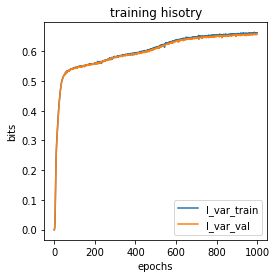

In [15]:
# Show training history
print('On test data:')
x_test = test_df['x'].values
y_test = test_df[y_cols].values

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
#ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
#ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
#ax.set_ylim([0, I_pred*1.2]);

In [16]:
interaction_term = model.get_nn().layers[2].get_weights()[4]
crp_weights = model.get_nn().layers[2].get_weights()[2][0]
rnap_weights = model.get_nn().layers[2].get_weights()[3][0]
print(f'interaction term = {interaction_term[0]*0.62:.3f} k_cal/mol')

interaction term = -3.151 k_cal/mol


In [17]:
# if I_pred > 0.7:
#     model.save(f'sort_seq_2010_models/model_{I_pred:.3f}_bits_I_{interaction_term[0]*0.62:.3f}_kcal_mol')

In [18]:
tsat_true = model.get_nn().layers[2].get_weights()[5][0]
tsat_true

9.503949

In [19]:
crp_df = pd.DataFrame(crp_weights,columns=model.alphabet)
rnap_df = pd.DataFrame(rnap_weights,columns=model.alphabet)

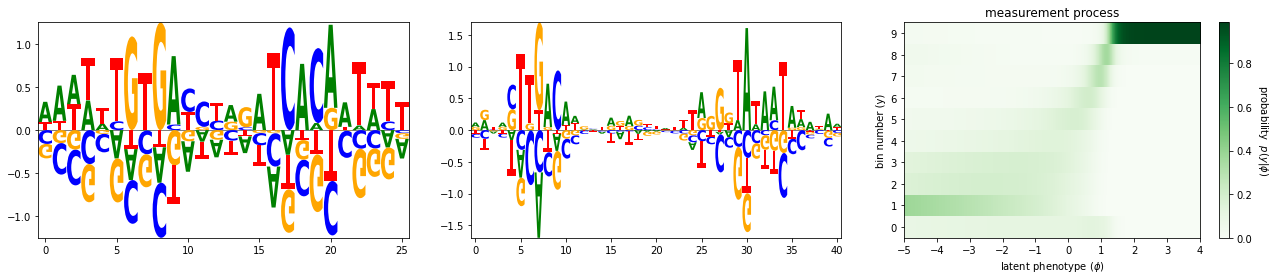

In [20]:
# # Get G-P map parameters in matrix form
# theta = model.get_theta(gauge='uniform')

# Create grid in phi space
phi_lim = [-5, 4]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# # Create figure with two panels
fig, axs = plt.subplots(1,3,figsize=[18,4])

logomaker.Logo(crp_df,ax=axs[0],center_values=True)
logomaker.Logo(rnap_df,ax=axs[1],center_values=True)

# # Right panel: draw measurement process as heatmap
ax = axs[2]
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
#fig.savefig('thermodynmic_custom_gpmap_mpa_visualization_sort_seq.png',bbox_index='tight',dpi=300)
# plt.show()

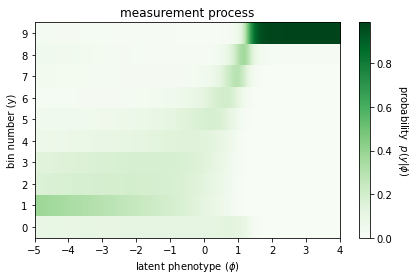

In [21]:
fig, ax = plt.subplots()
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
fig.savefig('measurement_process_sort_seq_2010.png',bbox_index='tight',dpi=300)

In [22]:
!pwd

/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local/mavenn/examples/other/custom_gpmap


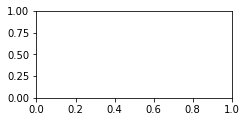

In [45]:
# # Create figure with two panels
fig, axs = plt.subplots(1,1,figsize=[3.5,1.6])

tick_spacing=4
# crp_logo  = logomaker.Logo(0.62*crp_df,ax=axs,center_values=True)
# crp_logo.style_xticks(anchor=0, spacing=tick_spacing, rotation=90)
# crp_logo.style_spines(visible=False)
# crp_logo.highlight_position_range(0,29,alpha=0.1,color='#9981B3',label='CRP')
# #crp_logo.style_glyphs_in_sequence(sequence='.TGTGA......TCACA...', color='darkred')
# crp_logo.ax.set_xticklabels('%+d'%x for x in np.arange(-75,-50+1,tick_spacing))
# #axs.set_xlabel('Position l')
# crp_logo.ax.set_ylabel("$-\Delta \Delta G$ (kcal/mol)", labelpad=-1)
# #axs.set_yticks([-1,0,1])
# #fig.savefig('crp_logo.png',bbox_inches='tight',dpi=200)
# plt.show()

# xylR_logo = logomaker.Logo(-0.62*xylR_df,ax=axs,center_values=True)
# xylR_logo.style_xticks(anchor=0, spacing=tick_spacing, rotation=90)
# xylR_logo.style_spines(visible=False)
# xylR_logo.ax.set_xticklabels('%+d'%x for x in np.arange(-104,-74+1,tick_spacing))
# xylR_logo.highlight_position_range(0,31,alpha=0.1,color='#9981B3',label='xylR')
# xylR_logo.ax.set_ylabel("$-\Delta \Delta G$ (kcal/mol)", labelpad=-1)
# axs.set_yticks([-0.5, 0, 0.5])
# fig.savefig('xylE_figure/xylR_logo.png',bbox_inches='tight',dpi=200)
# plt.show()

# rnap_logo = logomaker.Logo(0.62*rnap_df,ax=axs,center_values=True)
# rnap_logo.style_xticks(anchor=0, spacing=tick_spacing, rotation=90)
# rnap_logo.style_spines(visible=False)
# rnap_logo.highlight_position_range(0,41,alpha=0.7,color='lightcyan',label='RNAP')
# rnap_logo.ax.set_xticklabels('%+d'%x for x in np.arange(-41,-1+1,tick_spacing))
# rnap_logo.ax.set_ylabel("$-\Delta \Delta G$ (kcal/mol)", labelpad=-1)
# axs.set_xlabel('Position (relative to lacZ gene)')
# axs.set_yticks([-1, 0, 1])
# axs.xaxis.set_label_coords(0.5, -0.39)
# fig.savefig('rnap_logo.png',bbox_inches='tight',dpi=200)
# plt.show()

In [63]:
sim_df = model.simulate_dataset(51000)

In [64]:
# Separate test from data_df
ix_test = sim_df['set']=='test'
test_df = sim_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
sim_df = sim_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
sim_df.head()

test N: 10,234
training + validation N: 40,249


,set,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,x
0,validation,0,0,0,0,0,0,0,0,1,0,AATTGATTTGAGTCAGCTCACGCATTAGGCACCCCAGGCTTTAATC...
1,training,0,0,0,0,1,0,0,0,0,0,AATTAATGTGTGGTAGTTCACTCAGTAGGCACCCCAGGCTTTACAC...
2,training,0,1,0,0,0,0,0,0,0,0,AGTTCATGTGAGTCACCCCACTCATTAGGCACCCCAGCCTTTACGC...
3,validation,0,0,0,0,0,1,0,0,0,0,AATTAATGTGAGTTAGGTCACTCATTAGGCTCTCAAGTCTCTACAC...
4,training,0,0,0,0,0,0,1,0,0,0,AATTATTGTGAGTTCGCTTACTTATGAGGCACGCCAGGCTTTACTC...


In [65]:
sim_df.head(10)

,set,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,x
0,validation,0,0,0,0,0,0,0,0,1,0,AATTGATTTGAGTCAGCTCACGCATTAGGCACCCCAGGCTTTAATC...
1,training,0,0,0,0,1,0,0,0,0,0,AATTAATGTGTGGTAGTTCACTCAGTAGGCACCCCAGGCTTTACAC...
2,training,0,1,0,0,0,0,0,0,0,0,AGTTCATGTGAGTCACCCCACTCATTAGGCACCCCAGCCTTTACGC...
3,validation,0,0,0,0,0,1,0,0,0,0,AATTAATGTGAGTTAGGTCACTCATTAGGCTCTCAAGTCTCTACAC...
4,training,0,0,0,0,0,0,1,0,0,0,AATTATTGTGAGTTCGCTTACTTATGAGGCACGCCAGGCTTTACTC...
5,training,0,1,0,0,0,0,0,0,0,0,AATTAATGTGAGTTAGGTCACTCGTTAGGCACCCCAGGCTATGCAC...
6,training,0,0,1,0,0,0,0,0,0,0,AAGTAATGTATGGTAGCTCACTCCAAAGGCTTCCCAGTCTTTACAC...
7,training,0,0,0,0,0,1,0,0,0,0,AATTAATGTGTGTTAGCTCACTCATTAGGCACGCCAGGTTTTACAC...
8,validation,0,0,1,0,0,0,0,0,0,0,AATTAATATTAGTTAGCTCACTCATGAGGCACCGCAGGCTTTTCAC...
9,validation,0,0,0,0,0,0,0,0,1,0,AATTAATGTGAGTTAGCTCATGCTTTAGGCACCCCAGGCTTTAAAG...


In [66]:
# Create model
sim_model = mavenn.Model(L=L, 
                         Y=Y,
                         alphabet='dna', 
                         regression_type='MPA', 
                         gpmap_type='custom',
                         gpmap_kwargs=gpmap_kwargs,
                         custom_gpmap=ThermodynamicLayer)

In [67]:
# Set training data
sim_model.set_data(x=sim_df['x'],
                   y=sim_df[y_cols],
                   validation_flags=(sim_df['set']=='validation'),
                   shuffle=True)

# Fit model to data
sim_model.fit(learning_rate=.00025,
              epochs=1000,
              batch_size=100,
              early_stopping=True,
              early_stopping_patience=25,
              linear_initialization=True)


N = 40,754 observations set as training data.
Using 25.1% for validation.
Data shuffled.
Time to set data: 0.994 sec.
Epoch 1/1000
306/306 [==============================] - 4s 6ms/step - loss: 279.3326 - I_var: -0.0010 - val_loss: 273.4739 - val_I_var: -3.4175e-04
Epoch 2/1000
306/306 [==============================] - 1s 3ms/step - loss: 271.9179 - I_var: 0.0019 - val_loss: 266.7367 - val_I_var: 0.0029
Epoch 3/1000
306/306 [==============================] - 2s 5ms/step - loss: 265.2669 - I_var: 0.0085 - val_loss: 260.3740 - val_I_var: 0.0130
Epoch 4/1000
306/306 [==============================] - 1s 5ms/step - loss: 258.9987 - I_var: 0.0221 - val_loss: 254.3099 - val_I_var: 0.0299
Epoch 5/1000
306/306 [==============================] - 1s 4ms/step - loss: 252.8967 - I_var: 0.0462 - val_loss: 248.1335 - val_I_var: 0.0594
Epoch 6/1000
306/306 [==============================] - 1s 5ms/step - loss: 246.5336 - I_var: 0.0836 - val_loss: 242.0610 - val_I_var: 0.0980
Epoch 7/1000
306/306 [==

Epoch 57/1000
306/306 [==============================] - 2s 5ms/step - loss: 205.4019 - I_var: 0.4901 - val_loss: 208.0835 - val_I_var: 0.4422
Epoch 58/1000
306/306 [==============================] - 2s 6ms/step - loss: 205.9192 - I_var: 0.4907 - val_loss: 208.0266 - val_I_var: 0.4427
Epoch 59/1000
306/306 [==============================] - 2s 6ms/step - loss: 205.0849 - I_var: 0.4910 - val_loss: 207.9221 - val_I_var: 0.4438
Epoch 60/1000
306/306 [==============================] - 1s 5ms/step - loss: 204.8530 - I_var: 0.4918 - val_loss: 207.9148 - val_I_var: 0.4434
Epoch 61/1000
306/306 [==============================] - 1s 4ms/step - loss: 205.1175 - I_var: 0.4925 - val_loss: 207.8591 - val_I_var: 0.4437
Epoch 62/1000
306/306 [==============================] - 2s 6ms/step - loss: 205.1370 - I_var: 0.4924 - val_loss: 207.8078 - val_I_var: 0.4442
Epoch 63/1000
306/306 [==============================] - 2s 6ms/step - loss: 204.4605 - I_var: 0.4933 - val_loss: 207.7467 - val_I_var: 0.4444

Epoch 171/1000
306/306 [==============================] - 1s 3ms/step - loss: 202.7347 - I_var: 0.5084 - val_loss: 205.2384 - val_I_var: 0.4589
Epoch 172/1000
306/306 [==============================] - 1s 4ms/step - loss: 202.2187 - I_var: 0.5082 - val_loss: 205.2413 - val_I_var: 0.4588
Epoch 173/1000
306/306 [==============================] - 2s 5ms/step - loss: 202.7841 - I_var: 0.5082 - val_loss: 205.2002 - val_I_var: 0.4594
Epoch 174/1000
306/306 [==============================] - 1s 4ms/step - loss: 202.2096 - I_var: 0.5081 - val_loss: 205.2583 - val_I_var: 0.4584
Epoch 175/1000
306/306 [==============================] - 1s 5ms/step - loss: 202.5529 - I_var: 0.5082 - val_loss: 205.2517 - val_I_var: 0.4586
Epoch 176/1000
306/306 [==============================] - 1s 5ms/step - loss: 202.4618 - I_var: 0.5089 - val_loss: 205.2000 - val_I_var: 0.4593
Epoch 177/1000
306/306 [==============================] - 1s 4ms/step - loss: 202.4653 - I_var: 0.5085 - val_loss: 205.2698 - val_I_var:

Epoch 228/1000
306/306 [==============================] - 1s 5ms/step - loss: 202.0074 - I_var: 0.5199 - val_loss: 204.3142 - val_I_var: 0.4708
Epoch 229/1000
306/306 [==============================] - 1s 4ms/step - loss: 201.7596 - I_var: 0.5197 - val_loss: 204.3497 - val_I_var: 0.4706
Epoch 230/1000
306/306 [==============================] - 1s 4ms/step - loss: 201.3480 - I_var: 0.5193 - val_loss: 204.2563 - val_I_var: 0.4718
Epoch 231/1000
306/306 [==============================] - 1s 4ms/step - loss: 201.7408 - I_var: 0.5207 - val_loss: 204.2369 - val_I_var: 0.4720
Epoch 232/1000
306/306 [==============================] - 1s 4ms/step - loss: 201.5041 - I_var: 0.5207 - val_loss: 204.2145 - val_I_var: 0.4722
Epoch 233/1000
306/306 [==============================] - 1s 4ms/step - loss: 201.5976 - I_var: 0.5202 - val_loss: 204.1403 - val_I_var: 0.4735
Epoch 234/1000
306/306 [==============================] - 1s 3ms/step - loss: 201.6187 - I_var: 0.5210 - val_loss: 204.1649 - val_I_var:

Epoch 285/1000
306/306 [==============================] - 1s 5ms/step - loss: 201.0700 - I_var: 0.5283 - val_loss: 203.5110 - val_I_var: 0.4804
Epoch 286/1000
306/306 [==============================] - 1s 4ms/step - loss: 201.1718 - I_var: 0.5281 - val_loss: 203.4592 - val_I_var: 0.4811
Epoch 287/1000
306/306 [==============================] - 1s 5ms/step - loss: 201.3796 - I_var: 0.5284 - val_loss: 203.4784 - val_I_var: 0.4807
Epoch 288/1000
306/306 [==============================] - 1s 4ms/step - loss: 200.0807 - I_var: 0.5287 - val_loss: 203.5971 - val_I_var: 0.4791
Epoch 289/1000
306/306 [==============================] - 1s 4ms/step - loss: 200.8712 - I_var: 0.5283 - val_loss: 203.5058 - val_I_var: 0.4802
Epoch 290/1000
306/306 [==============================] - 1s 4ms/step - loss: 201.0109 - I_var: 0.5281 - val_loss: 203.5585 - val_I_var: 0.4795
Epoch 291/1000
306/306 [==============================] - 1s 4ms/step - loss: 200.9038 - I_var: 0.5287 - val_loss: 203.6061 - val_I_var:

Epoch 342/1000
306/306 [==============================] - 1s 4ms/step - loss: 199.9307 - I_var: 0.5332 - val_loss: 203.0037 - val_I_var: 0.4846
Epoch 343/1000
306/306 [==============================] - 1s 4ms/step - loss: 200.4238 - I_var: 0.5324 - val_loss: 203.1103 - val_I_var: 0.4830
Epoch 344/1000
306/306 [==============================] - 1s 4ms/step - loss: 200.3225 - I_var: 0.5315 - val_loss: 202.9761 - val_I_var: 0.4850
Epoch 345/1000
306/306 [==============================] - 1s 3ms/step - loss: 199.7619 - I_var: 0.5320 - val_loss: 202.9879 - val_I_var: 0.4849
Epoch 346/1000
306/306 [==============================] - 1s 4ms/step - loss: 199.7609 - I_var: 0.5322 - val_loss: 203.0165 - val_I_var: 0.4842
Epoch 347/1000
306/306 [==============================] - 1s 4ms/step - loss: 200.3712 - I_var: 0.5329 - val_loss: 202.9653 - val_I_var: 0.4849
Epoch 348/1000
306/306 [==============================] - 1s 4ms/step - loss: 199.8963 - I_var: 0.5321 - val_loss: 202.9032 - val_I_var:

Epoch 399/1000
306/306 [==============================] - 1s 3ms/step - loss: 200.1158 - I_var: 0.5362 - val_loss: 202.7047 - val_I_var: 0.4871
Epoch 400/1000
306/306 [==============================] - 1s 4ms/step - loss: 200.1067 - I_var: 0.5361 - val_loss: 202.6080 - val_I_var: 0.4886
Epoch 401/1000
306/306 [==============================] - 1s 5ms/step - loss: 199.3826 - I_var: 0.5361 - val_loss: 202.5459 - val_I_var: 0.4895
Epoch 402/1000
306/306 [==============================] - 1s 4ms/step - loss: 199.7797 - I_var: 0.5364 - val_loss: 202.5639 - val_I_var: 0.4892TA: 0s - loss: 199.6685 - I_var
Epoch 403/1000
306/306 [==============================] - 2s 5ms/step - loss: 200.0598 - I_var: 0.5360 - val_loss: 202.7659 - val_I_var: 0.4862
Epoch 404/1000
306/306 [==============================] - 1s 4ms/step - loss: 199.8404 - I_var: 0.5366 - val_loss: 202.5956 - val_I_var: 0.4886
Epoch 405/1000
306/306 [==============================] - 1s 3ms/step - loss: 200.4594 - I_var: 0.5365 - 

Epoch 512/1000
306/306 [==============================] - 1s 4ms/step - loss: 199.0513 - I_var: 0.5442 - val_loss: 201.8653 - val_I_var: 0.4973
Epoch 513/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.5911 - I_var: 0.5438 - val_loss: 201.8297 - val_I_var: 0.4980
Epoch 514/1000
306/306 [==============================] - 1s 3ms/step - loss: 199.1333 - I_var: 0.5435 - val_loss: 201.9062 - val_I_var: 0.4968
Epoch 515/1000
306/306 [==============================] - 1s 4ms/step - loss: 199.5941 - I_var: 0.5444 - val_loss: 201.8870 - val_I_var: 0.4971
Epoch 516/1000
306/306 [==============================] - 1s 4ms/step - loss: 199.8467 - I_var: 0.5444 - val_loss: 201.8766 - val_I_var: 0.4974
Epoch 517/1000
306/306 [==============================] - 1s 4ms/step - loss: 199.4983 - I_var: 0.5442 - val_loss: 201.8649 - val_I_var: 0.4976
Epoch 518/1000
306/306 [==============================] - 1s 4ms/step - loss: 199.7983 - I_var: 0.5440 - val_loss: 201.8988 - val_I_var:

Epoch 569/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.6801 - I_var: 0.5473 - val_loss: 201.6415 - val_I_var: 0.5004
Epoch 570/1000
306/306 [==============================] - 1s 4ms/step - loss: 199.3911 - I_var: 0.5470 - val_loss: 201.5909 - val_I_var: 0.5009
Epoch 571/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.2354 - I_var: 0.5484 - val_loss: 201.7506 - val_I_var: 0.4983
Epoch 572/1000
306/306 [==============================] - 1s 3ms/step - loss: 198.9655 - I_var: 0.5475 - val_loss: 201.5077 - val_I_var: 0.5021
Epoch 573/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.8708 - I_var: 0.5478 - val_loss: 201.5994 - val_I_var: 0.5007
Epoch 574/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.7738 - I_var: 0.5481 - val_loss: 201.5669 - val_I_var: 0.5012
Epoch 575/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.8952 - I_var: 0.5480 - val_loss: 201.5018 - val_I_var:

Epoch 626/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.6568 - I_var: 0.5505 - val_loss: 201.3212 - val_I_var: 0.5045
Epoch 627/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.3851 - I_var: 0.5510 - val_loss: 201.2734 - val_I_var: 0.5052
Epoch 628/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.4475 - I_var: 0.5508 - val_loss: 201.2587 - val_I_var: 0.5054
Epoch 629/1000
306/306 [==============================] - 1s 3ms/step - loss: 198.7905 - I_var: 0.5508 - val_loss: 201.3138 - val_I_var: 0.5048
Epoch 630/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.6096 - I_var: 0.5517 - val_loss: 201.3914 - val_I_var: 0.5036
Epoch 631/1000
306/306 [==============================] - 1s 4ms/step - loss: 199.2951 - I_var: 0.5509 - val_loss: 201.3736 - val_I_var: 0.5037
Epoch 632/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.4001 - I_var: 0.5508 - val_loss: 201.4068 - val_I_var:

Epoch 683/1000
306/306 [==============================] - 1s 4ms/step - loss: 199.1167 - I_var: 0.5540 - val_loss: 201.0851 - val_I_var: 0.5073
Epoch 684/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.9167 - I_var: 0.5533 - val_loss: 201.1434 - val_I_var: 0.5065
Epoch 685/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.3482 - I_var: 0.5538 - val_loss: 201.0786 - val_I_var: 0.5075
Epoch 686/1000
306/306 [==============================] - 1s 3ms/step - loss: 199.3515 - I_var: 0.5535 - val_loss: 201.1467 - val_I_var: 0.5066
Epoch 687/1000
306/306 [==============================] - 1s 4ms/step - loss: 199.0100 - I_var: 0.5535 - val_loss: 201.2276 - val_I_var: 0.5054
Epoch 688/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.7298 - I_var: 0.5540 - val_loss: 201.0656 - val_I_var: 0.5079
Epoch 689/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.1353 - I_var: 0.5534 - val_loss: 200.9875 - val_I_var:

Epoch 740/1000
306/306 [==============================] - 1s 4ms/step - loss: 199.4295 - I_var: 0.5554 - val_loss: 201.0056 - val_I_var: 0.5078
Epoch 741/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.3120 - I_var: 0.5553 - val_loss: 200.8512 - val_I_var: 0.5102
Epoch 742/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.7818 - I_var: 0.5557 - val_loss: 200.8992 - val_I_var: 0.5095
Epoch 743/1000
306/306 [==============================] - 1s 3ms/step - loss: 198.6282 - I_var: 0.5558 - val_loss: 200.8729 - val_I_var: 0.5097
Epoch 744/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.6792 - I_var: 0.5560 - val_loss: 201.0413 - val_I_var: 0.5073
Epoch 745/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.5751 - I_var: 0.5554 - val_loss: 200.8872 - val_I_var: 0.5096
Epoch 746/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.2884 - I_var: 0.5554 - val_loss: 200.8632 - val_I_var:

Epoch 797/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.4177 - I_var: 0.5565 - val_loss: 200.7562 - val_I_var: 0.5105
Epoch 798/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.8703 - I_var: 0.5569 - val_loss: 200.8924 - val_I_var: 0.5086
Epoch 799/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.0054 - I_var: 0.5564 - val_loss: 200.6917 - val_I_var: 0.5117
Epoch 800/1000
306/306 [==============================] - 1s 3ms/step - loss: 197.9834 - I_var: 0.5564 - val_loss: 200.7441 - val_I_var: 0.5108
Epoch 801/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.2568 - I_var: 0.5572 - val_loss: 200.7690 - val_I_var: 0.5105
Epoch 802/1000
306/306 [==============================] - 1s 3ms/step - loss: 198.5478 - I_var: 0.5570 - val_loss: 200.7001 - val_I_var: 0.5113
Epoch 803/1000
306/306 [==============================] - 1s 4ms/step - loss: 199.0979 - I_var: 0.5566 - val_loss: 200.8157 - val_I_var:

Epoch 854/1000
306/306 [==============================] - 1s 3ms/step - loss: 198.7606 - I_var: 0.5576 - val_loss: 200.6330 - val_I_var: 0.5114
Epoch 855/1000
306/306 [==============================] - 1s 3ms/step - loss: 197.9200 - I_var: 0.5581 - val_loss: 200.5828 - val_I_var: 0.5124
Epoch 856/1000
306/306 [==============================] - 1s 3ms/step - loss: 197.4408 - I_var: 0.5583 - val_loss: 200.5911 - val_I_var: 0.5121
Epoch 857/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.1025 - I_var: 0.5570 - val_loss: 200.6309 - val_I_var: 0.5117
Epoch 858/1000
306/306 [==============================] - 1s 3ms/step - loss: 198.3891 - I_var: 0.5574 - val_loss: 200.5541 - val_I_var: 0.5127
Epoch 859/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.1144 - I_var: 0.5576 - val_loss: 200.6315 - val_I_var: 0.5114
Epoch 860/1000
306/306 [==============================] - 1s 4ms/step - loss: 197.7524 - I_var: 0.5580 - val_loss: 200.5491 - val_I_var:

Epoch 967/1000
306/306 [==============================] - 1s 4ms/step - loss: 197.5967 - I_var: 0.5580 - val_loss: 200.4178 - val_I_var: 0.5132
Epoch 968/1000
306/306 [==============================] - 1s 4ms/step - loss: 197.3633 - I_var: 0.5593 - val_loss: 200.3692 - val_I_var: 0.5139
Epoch 969/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.2931 - I_var: 0.5590 - val_loss: 200.4295 - val_I_var: 0.5130
Epoch 970/1000
306/306 [==============================] - 1s 4ms/step - loss: 198.1091 - I_var: 0.5590 - val_loss: 200.3894 - val_I_var: 0.5136
Epoch 971/1000
306/306 [==============================] - 1s 4ms/step - loss: 197.8159 - I_var: 0.5591 - val_loss: 200.4424 - val_I_var: 0.5127
Epoch 972/1000
306/306 [==============================] - 1s 4ms/step - loss: 197.7105 - I_var: 0.5587 - val_loss: 200.4192 - val_I_var: 0.5131
Epoch 973/1000
306/306 [==============================] - 1s 3ms/step - loss: 198.0747 - I_var: 0.5587 - val_loss: 200.4520 - val_I_var:

In [68]:
#sim_model = mavenn.load('simulation_models/N_50/sim_model_4')

On test data:
I_var_test: 0.541 +- 0.010 bits
I_pred_test: 0.568 +- 0.012 bits


Text(0.5, 1.0, 'training hisotry')

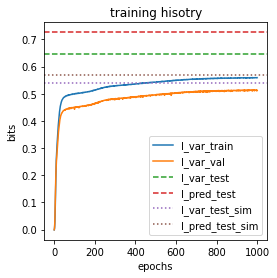

In [69]:
# Show training history
print('On test data:')
x_test = test_df['x'].values
y_test = test_df[y_cols].values

# Compute likelihood information
I_var_sim, dI_var_sim =  sim_model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var_sim:.3f} +- {dI_var_sim:.3f} bits') 

# Compute predictive information
I_pred_sim, dI_pred_sim = sim_model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred_sim:.3f} +- {dI_pred_sim:.3f} bits')

I_var_hist_sim = sim_model.history['I_var']
val_I_var_hist_sim = sim_model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist_sim, label='I_var_train')
ax.plot(val_I_var_hist_sim, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle='--', label='I_var_test')
ax.axhline(I_pred, color='C3', linestyle='--', label='I_pred_test')

ax.axhline(I_var_sim, color='C4', linestyle=':', label='I_var_test_sim')
ax.axhline(I_pred_sim, color='C5', linestyle=':', label='I_pred_test_sim')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
#ax.set_ylim([0, I_pred*1.2]);

In [70]:
interaction_term_sim = sim_model.get_nn().layers[2].get_weights()[4]
crp_weights_sim = sim_model.get_nn().layers[2].get_weights()[2][0]
rnap_weights_sim = sim_model.get_nn().layers[2].get_weights()[3][0]
print(f'interaction term = {interaction_term_sim[0]/1.688:.3f} k_cal/mol')

interaction term = -3.054 k_cal/mol


In [71]:
tsat_sim = sim_model.get_nn().layers[2].get_weights()[5][0]
tsat_sim

10.525504

In [72]:
crp_df_sim = pd.DataFrame(crp_weights_sim,columns=model.alphabet)
rnap_df_sim = pd.DataFrame(rnap_weights_sim,columns=model.alphabet)

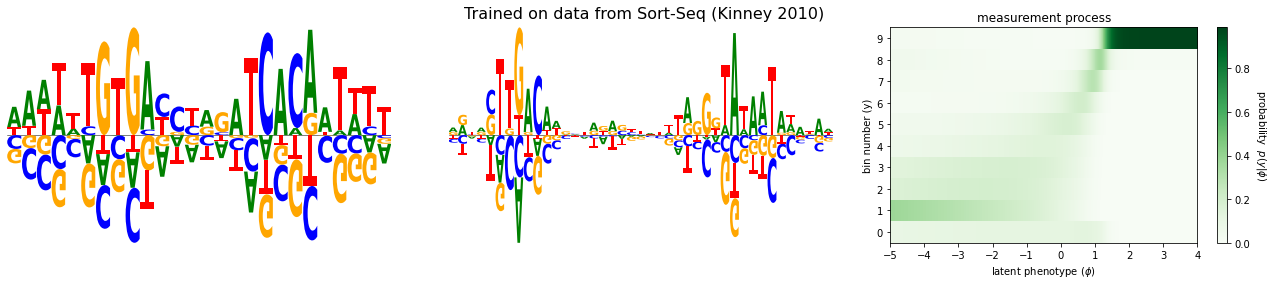

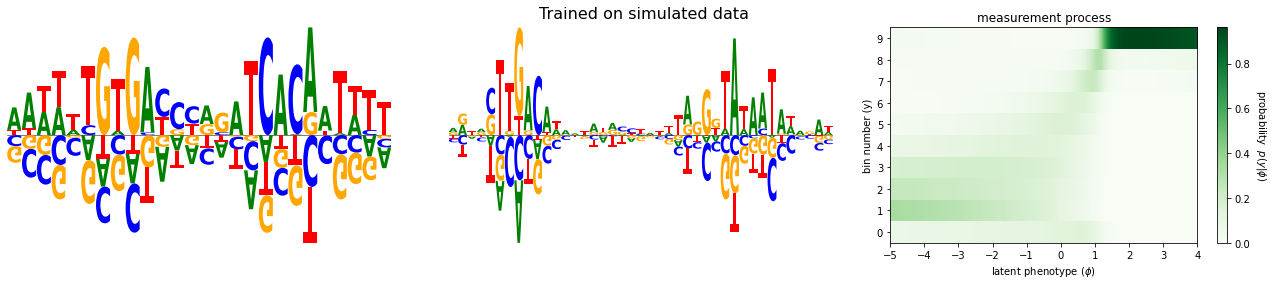

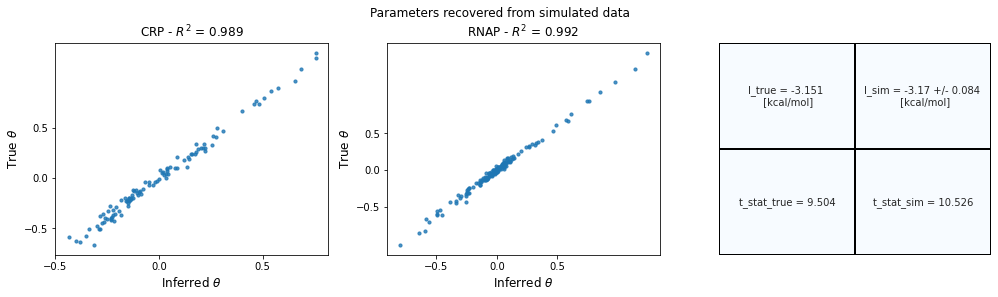

In [82]:
# # Create figure with two panels
fig, axs = plt.subplots(1,3,figsize=[18,4])

crp_logo = logomaker.Logo(crp_df,ax=axs[0],center_values=True)
crp_logo.style_spines(visible=False)
axs[0].set_xticks([])
axs[0].set_yticks([])
rnap_logo = logomaker.Logo(rnap_df,ax=axs[1],center_values=True)
rnap_logo.style_spines(visible=False)
axs[1].set_xticks([])
axs[1].set_yticks([])

# # Right panel: draw measurement process as heatmap
ax = axs[2]
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

fig.suptitle('Trained on data from Sort-Seq (Kinney 2010)',fontsize=16)
# Fix up plot
fig.tight_layout(w_pad=3)

# # Get G-P map parameters in matrix form
# theta = model.get_theta(gauge='uniform')

# Create grid in phi space
phi_lim = [-5, 4]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = sim_model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process_sim = sim_model.p_of_y_given_phi(y_all, phi_grid)

# # Create figure with two panels
fig, axs = plt.subplots(1,3,figsize=[18,4])

crp_logo_sim = logomaker.Logo(crp_df_sim,ax=axs[0],center_values=True)
crp_logo_sim.style_spines(visible=False)
axs[0].set_xticks([])
axs[0].set_yticks([])
rnap_logo_sim =logomaker.Logo(rnap_df_sim,ax=axs[1],center_values=True)
rnap_logo_sim.style_spines(visible=False)
axs[1].set_xticks([])
axs[1].set_yticks([])

# # Right panel: draw measurement process as heatmap
ax = axs[2]
im = ax.imshow(measurement_process_sim,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

fig.suptitle('Trained on simulated data',fontsize=16)
# Fix up plot
fig.tight_layout(w_pad=3)
#fig.savefig('thermodynmic_custom_gpmap_mpa_visualization_sort_seq.png',bbox_index='tight',dpi=300)
# plt.show()

fig1, axs1 = plt.subplots(1,3,figsize=[14,4])

axs1[0].scatter(crp_logo_sim.df.values.ravel(),crp_logo.df.values.ravel(),s=10,alpha=0.8,c='C0')
axs1[0].set_xlabel('Inferred $\\theta$',fontsize=12)
axs1[0].set_ylabel('True $\\theta$',fontsize=12)
Rsq_crp = np.corrcoef(crp_df_sim.values.ravel(),crp_df.values.ravel())[0][1]**2
axs1[0].set_title(f'CRP - $R^2$ = {Rsq_crp:.3f}',fontsize=12)
axs1[0].set_xticks([-0.5,0,0.5])
axs1[0].set_yticks([-0.5,0,0.5])

axs1[1].scatter(rnap_logo_sim.df.values.ravel(),rnap_logo.df.values.ravel(),s=10,alpha=0.8,c='C0')
Rsq_rnap = np.corrcoef(rnap_df_sim.values.ravel(),rnap_df.values.ravel())[0][1]**2
axs1[1].set_title(f'RNAP - $R^2$ = {Rsq_rnap:.3f}',fontsize=12)
axs1[1].set_xlabel('Inferred $\\theta$',fontsize=12)
axs1[1].set_ylabel('True $\\theta$',fontsize=12)
axs1[1].set_xticks([-0.5,0,0.5])
axs1[1].set_yticks([-0.5,0,0.5])

params = np.ones((2,2))

#labels = np.asarray([[f'I_true = {interaction_term[0]/1.688:.3f} \n [kcal/mol]', f'I_sim = {interaction_term_sim[0]/1.688:.3f} \n [kcal/mol]'],
labels = np.asarray([[f'I_true = {interaction_term[0]*0.62:.3f} \n [kcal/mol]', f'I_sim = -3.17 +/- 0.084 \n [kcal/mol]'],
            [f't_stat_true = {tsat_true:.3f}', f't_stat_sim = {tsat_sim:.3f}']])

sns.heatmap(params,
            annot=labels,
            fmt="",
            linewidths=1, 
            linecolor='black',
            cmap='Blues',
            xticklabels=[],
            yticklabels=[],
            cbar=False,
            ax=axs1[2])

fig1.suptitle('Parameters recovered from simulated data',fontsize=12,y=1.02)

#sns.heatmap(,ax=axs1[1])
fig1.tight_layout()

In [28]:
#sim_model
#sim_model.save('simulation_models/N_50/sim_model_6')

In [29]:
!ls simulation_models/N_50

sim_model_1.h5     sim_model_2.pickle sim_model_4.h5     sim_model_5.pickle
sim_model_1.pickle sim_model_3.h5     sim_model_4.pickle sim_model_6.h5
sim_model_2.h5     sim_model_3.pickle sim_model_5.h5     sim_model_6.pickle


In [30]:
interaction_terms_simulations = []
for model_index in ['1','2','3','4','5','6']:
    temp_model = mavenn.load(f'simulation_models/N_50/sim_model_{model_index}',verbose=False)
    interaction_term_sim = temp_model.get_nn().layers[2].get_weights()[4]
    interaction_terms_simulations.append(interaction_term_sim[0]*0.62)

In [31]:
np.mean(interaction_terms_simulations),np.std(interaction_terms_simulations)

(-3.179853730201721, 0.08407293981555704)